In [ ]:
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

<>:1: SyntaxWarning: invalid escape sequence '\T'
<>:1: SyntaxWarning: invalid escape sequence '\T'
C:\Users\saifk\AppData\Local\Temp\ipykernel_23376\388453675.py:1: SyntaxWarning: invalid escape sequence '\T'
  train_dir = "Teeth DataSet\Teeth_Dataset\Training"


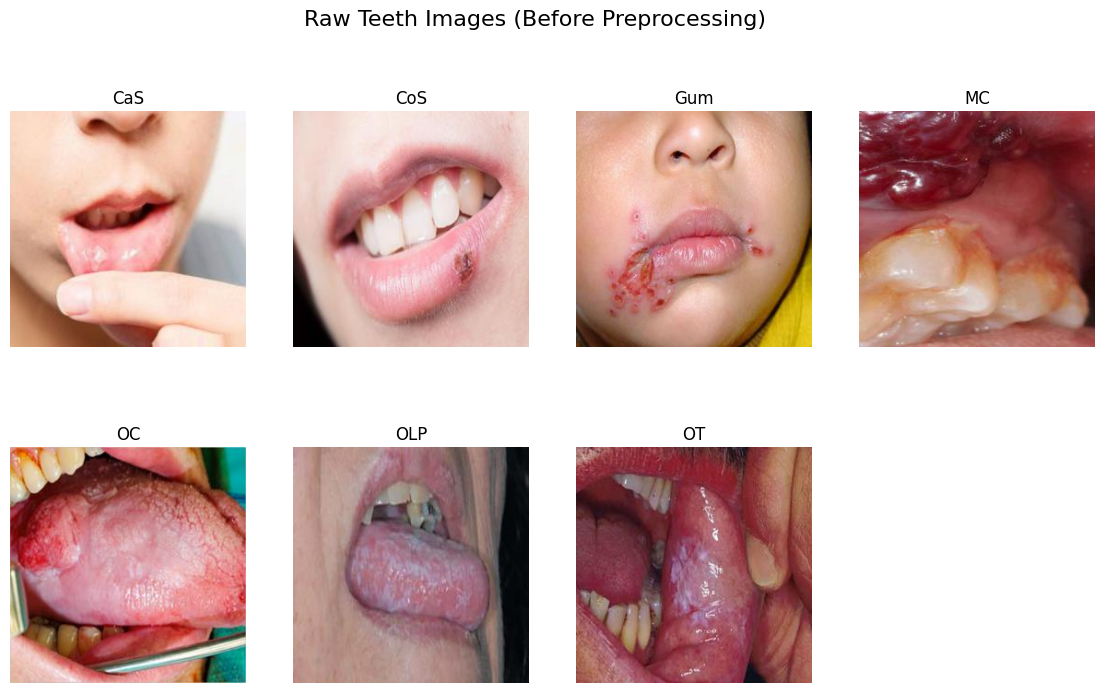

In [ ]:
train_dir = "Teeth DataSet\Teeth_Dataset\Training"

classes = os.listdir(train_dir)

plt.figure(figsize=(14, 8))

for i, cls in enumerate(classes):
    cls_path = os.path.join(train_dir, cls)
    img_name = os.listdir(cls_path)[0]  
    img_path = os.path.join(cls_path, img_name)

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(2, 4, i+1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis("off")

plt.suptitle("Raw Teeth Image", fontsize=16)
plt.show()

In [19]:
def get_class_distribution(directory):
    classes = os.listdir(directory)
    data = {}

    for cls in classes:
        cls_path = os.path.join(directory, cls)
        if os.path.isdir(cls_path):
            data[cls] = len(os.listdir(cls_path))

    return data

train_dist = get_class_distribution("Teeth DataSet\Teeth_Dataset\Training")
val_dist   = get_class_distribution("Teeth DataSet\Teeth_Dataset\Validation")
test_dist  = get_class_distribution("Teeth DataSet\Teeth_Dataset\Testing")

df = pd.DataFrame({
    "Train": train_dist,
    "Validation": val_dist,
    "Test": test_dist
})

<>:12: SyntaxWarning: invalid escape sequence '\T'
<>:13: SyntaxWarning: invalid escape sequence '\T'
<>:14: SyntaxWarning: invalid escape sequence '\T'
<>:12: SyntaxWarning: invalid escape sequence '\T'
<>:13: SyntaxWarning: invalid escape sequence '\T'
<>:14: SyntaxWarning: invalid escape sequence '\T'
C:\Users\saifk\AppData\Local\Temp\ipykernel_23376\3903324801.py:12: SyntaxWarning: invalid escape sequence '\T'
  train_dist = get_class_distribution("Teeth DataSet\Teeth_Dataset\Training")
C:\Users\saifk\AppData\Local\Temp\ipykernel_23376\3903324801.py:13: SyntaxWarning: invalid escape sequence '\T'
  val_dist   = get_class_distribution("Teeth DataSet\Teeth_Dataset\Validation")
C:\Users\saifk\AppData\Local\Temp\ipykernel_23376\3903324801.py:14: SyntaxWarning: invalid escape sequence '\T'
  test_dist  = get_class_distribution("Teeth DataSet\Teeth_Dataset\Testing")


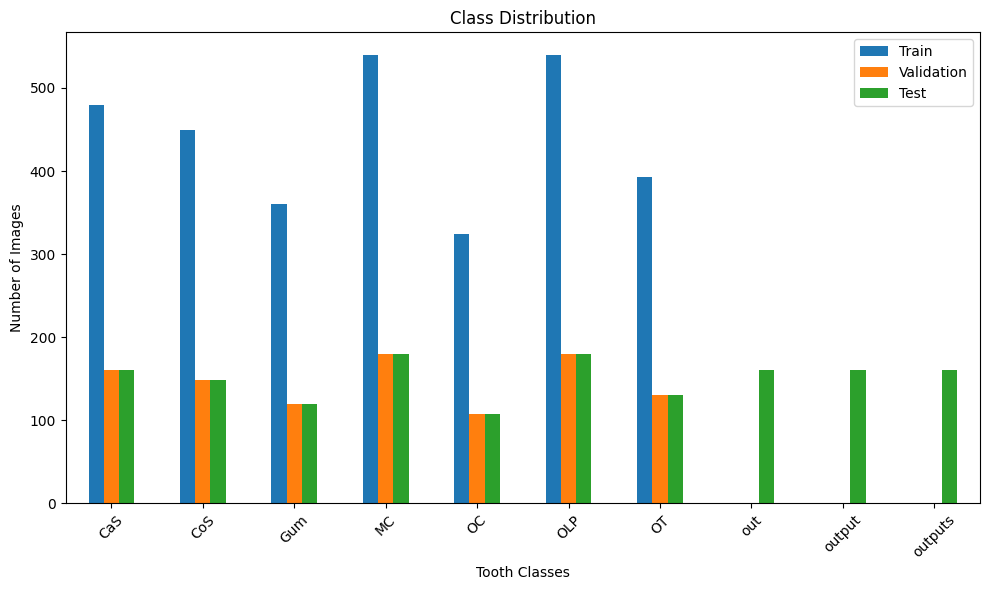

In [18]:
df.plot(kind="bar", figsize=(10,6))
plt.title("Class Distribution")
plt.xlabel("Tooth Classes")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1/255)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D,
    Flatten, Dense, Dropout
)

NUM_CLASSES = 7

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])

In [24]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,863 (42.61 MB)

 Trainable params: 11,169,863 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
history = model.fit(
    train_datagen,
    validation_data=val_test_datagen,
    epochs=20
)


ValueError: Unrecognized data type: x=<keras.src.legacy.preprocessing.image.ImageDataGenerator object at 0x000002BB373D5820> (of type <class 'keras.src.legacy.preprocessing.image.ImageDataGenerator'>)

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()
